In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.feature_selection import r_regression

df_demographics = pd.read_csv("../data/raw/kaggle/demographics.csv")
df_show = pd.read_csv("../data/raw/kaggle/show info.csv")

# Animated Shows

## Cleaning

In [2]:
# Merging the dataframes by ID, and droping unnecessary columns
df = pd.merge(df_demographics, df_show.drop('show_title', axis=1), on='ID').drop('ID', axis=1)
df.head(2)

,show_title,confirmation_date,character_name,race,gender,orientation,role,representation,TV_rating,IMDB_total_votes,IMDB_rating,seasons,total_episodes,start_date,end_date,duration,network,genre
0,3Below: Tales of Arcadia,7/12/2019,Shannon Longhannon,White,Cis Woman,Lesbian,Recurring Character,Explicit,TV-Y7,5776,7.7,2,26,12/21/2018,7/12/2019,203,Netflix,"action, adventure, comedy, family, fantasy, sc..."
1,Adventure Time,5/17/2010,Princess Bubblegum,NaN,Cis Woman,Undetermined,Recurring Character,Explicit,TV-PG,86837,8.6,10,282,4/5/2010,7/20/2018,2839,Cartoon Network,"action, adventure, comedy, family, fantasy, sc..."


### Dates

In [3]:
# Creating a year column
df['confirmation_date'] = pd.to_datetime(df['confirmation_date'])
df["year"] = df["confirmation_date"].dt.year

# Dropping the confirmation, start and end dates
df = df.drop('confirmation_date', axis=1)
df = df.drop('start_date', axis=1)
df = df.drop('end_date', axis=1)
df.head(2)

,show_title,character_name,race,gender,orientation,role,representation,TV_rating,IMDB_total_votes,IMDB_rating,seasons,total_episodes,duration,network,genre,year
0,3Below: Tales of Arcadia,Shannon Longhannon,White,Cis Woman,Lesbian,Recurring Character,Explicit,TV-Y7,5776,7.7,2,26,203,Netflix,"action, adventure, comedy, family, fantasy, sc...",2019
1,Adventure Time,Princess Bubblegum,NaN,Cis Woman,Undetermined,Recurring Character,Explicit,TV-PG,86837,8.6,10,282,2839,Cartoon Network,"action, adventure, comedy, family, fantasy, sc...",2010


## Linear Regression of Queer Characters based on Year

In [4]:
queer_characters = df.groupby(['year', 'orientation']).size().unstack().drop('Straight', axis=1).fillna(0).sum(axis=1)
queer_characters = pd.DataFrame(queer_characters, columns=['Queer Characters'])
queer_characters = queer_characters.reset_index()
queer_characters.head()

,year,Queer Characters
0,1991,2.0
1,1994,3.0
2,1995,2.0
3,1996,1.0
4,1997,8.0


In [5]:
# Encoding the year
queer_characters['year'] = queer_characters['year'].astype("object")
encoder = OrdinalEncoder()
a = np.array(queer_characters['year']).reshape(-1,1)
queer_characters['year_encoded'] = encoder.fit_transform(a) 
queer_characters.head()

d:\anaconda3\envs\iteso\lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
d:\anaconda3\envs\iteso\lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)


,year,Queer Characters,year_encoded
0,1991,2.0,1
1,1994,3.0,2
2,1995,2.0,3
3,1996,1.0,4
4,1997,8.0,5


In [6]:
trans_characters = df.groupby(['year', 'gender']).size().unstack().drop(['Cis Man', 'Cis Woman'], axis=1).fillna(0).sum(axis=1)
trans_characters = pd.DataFrame(trans_characters, columns=['Trans Characters'])
trans_characters = trans_characters.reset_index()
trans_characters.head()

,year,Trans Characters
0,1991,0.0
1,1994,0.0
2,1995,0.0
3,1996,0.0
4,1997,1.0


In [7]:
# Encoding the year
trans_characters['year'] = trans_characters['year'].astype("object")
encoder = OrdinalEncoder()
a = np.array(trans_characters['year']).reshape(-1,1)
trans_characters['year_encoded'] = encoder.fit_transform(a) 
trans_characters.head()

d:\anaconda3\envs\iteso\lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
d:\anaconda3\envs\iteso\lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)


,year,Trans Characters,year_encoded
0,1991,0.0,1
1,1994,0.0,2
2,1995,0.0,3
3,1996,0.0,4
4,1997,1.0,5


## Modeling

In [8]:
# Establishing the x and y’s
x_queer = np.array(queer_characters['year_encoded']).reshape(-1,1)
y_queer = np.array(queer_characters['Queer Characters']).reshape(-1,1)

x_trans = np.array(trans_characters['year_encoded']).reshape(-1,1)
y_trans = np.array(trans_characters['Trans Characters']).reshape(-1,1)

The Pearson Regression Coefficients for the queer and trans variables are:

In [9]:
r_regression(x_queer, y_queer.ravel()), r_regression(x_trans, y_trans.ravel())

(array([0.73581965]), array([0.71311547]))

This indicates that there’s a linear regression between the data, and thus we can proceed with the linear regressions.

In [10]:
model_queer = LinearRegression()
model_queer.fit(x_queer,y_queer)

model_trans = LinearRegression()
model_trans.fit(x_trans,y_trans)

LinearRegression()

In [11]:
queer_pred = model_queer.predict(x_queer)
trans_pred = model_trans.predict(x_trans)

Scores for the models:

In [12]:
model_queer.score(x_queer,y_queer), model_trans.score(x_trans,y_trans)

(0.5414305623427631, 0.5085336738659708)

The model scores are not very high.

[Text(0.5, 1.0, 'Trans Characters on Animated Shows')]

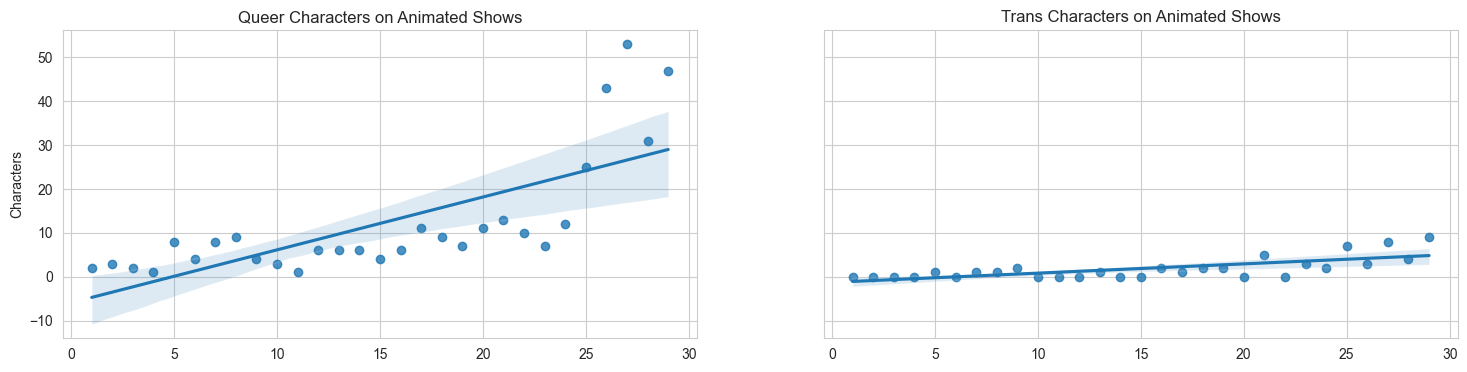

In [13]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(18,4), sharey=True)
sns.regplot(x=x_queer, y=y_queer, ax=axes[0]).set(title='Queer Characters on Animated Shows', ylabel='Characters')
sns.regplot(x=x_trans, y=y_trans, ax=axes[1]).set(title='Trans Characters on Animated Shows')

## Encoding

To do a clustering model of the data, first we have to encode the categorical values. We can either do this by ordinal encoding or one-hot encoding. Because some features have multiple categorical values attached to them, such as network and genre, I’m gonna apply a one-hot encoding, while the rest of the categorical values will have a ordinal encoding.

Although the one-hot encodings will cause an increase in dimensionality, the multiple values make it hard to ordinal encode the data.

In [14]:
df_encoded = df.copy()
df_encoded = df_encoded.drop(columns=['show_title', 'character_name'])
df_encoded.head(2)

,race,gender,orientation,role,representation,TV_rating,IMDB_total_votes,IMDB_rating,seasons,total_episodes,duration,network,genre,year
0,White,Cis Woman,Lesbian,Recurring Character,Explicit,TV-Y7,5776,7.7,2,26,203,Netflix,"action, adventure, comedy, family, fantasy, sc...",2019
1,NaN,Cis Woman,Undetermined,Recurring Character,Explicit,TV-PG,86837,8.6,10,282,2839,Cartoon Network,"action, adventure, comedy, family, fantasy, sc...",2010


### Network

In [15]:
network = df_encoded["network"].str.split(", ", expand=True)
network.head()

,0,1,2
0,Netflix,None,None
1,Cartoon Network,None,None
2,Cartoon Network,None,None
3,Cartoon Network,None,None
4,HBO Max,None,None


In [16]:
encoder = OneHotEncoder(return_df=True,use_cat_names=True)
network_encoded = encoder.fit_transform(network)
network_encoded.columns = [col.split("_")[-1] for col in network_encoded.columns]
network_encoded = network_encoded.drop(columns=["nan"])
network_encoded = network_encoded.T.groupby(network_encoded.columns).sum().T
network_encoded.head()

,ABC,ABC Kids,Adult Swim,Amazon Prime,CW Seed,Cartoon Network,Comedy Central,Crunchyroll Originals,DC Universe,Disney Channel,...,Peacock,Rooster Teeth,Showtime,SyFy,TBS,The Hub,The WB,Web Series,Webseries,YouTube
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df_encoded = pd.concat([df_encoded, network_encoded], axis=1)
df_encoded = df_encoded.drop(columns=['network'])
df_encoded.head()

,race,gender,orientation,role,representation,TV_rating,IMDB_total_votes,IMDB_rating,seasons,total_episodes,...,Peacock,Rooster Teeth,Showtime,SyFy,TBS,The Hub,The WB,Web Series,Webseries,YouTube
0,White,Cis Woman,Lesbian,Recurring Character,Explicit,TV-Y7,5776,7.7,2,26,...,0,0,0,0,0,0,0,0,0,0
1,NaN,Cis Woman,Undetermined,Recurring Character,Explicit,TV-PG,86837,8.6,10,282,...,0,0,0,0,0,0,0,0,0,0
2,NaN,Cis Woman,Undetermined,Recurring Character,Explicit,TV-PG,86837,8.6,10,282,...,0,0,0,0,0,0,0,0,0,0
3,NaN,Agender,Undetermined,Recurring Character,Explicit,TV-PG,86837,8.6,10,282,...,0,0,0,0,0,0,0,0,0,0
4,NaN,Cis Woman,Ambiguous,Recurring Character,Implicit,TV-PG,3322,8.7,1,4,...,0,0,0,0,0,0,0,0,0,0


### Genre

In [18]:
genre = df_encoded["genre"].str.split(", ", expand=True)
genre.head()

,0,1,2,3,4,5,6,7,8,9
0,action,adventure,comedy,family,fantasy,science fiction,None,None,None,None
1,action,adventure,comedy,family,fantasy,science fiction,None,None,None,None
2,action,adventure,comedy,family,fantasy,science fiction,None,None,None,None
3,action,adventure,comedy,family,fantasy,science fiction,None,None,None,None
4,action,adventure,comedy,family,fantasy,science fiction,None,None,None,None


In [19]:
encoder = OneHotEncoder(return_df=True,use_cat_names=True)
genre_encoded = encoder.fit_transform(genre)
genre_encoded.columns = [col.split("_")[-1] for col in genre_encoded.columns]
genre_encoded = genre_encoded.drop(columns=["nan"])
genre_encoded = genre_encoded.T.groupby(genre_encoded.columns).sum().T
genre_encoded.head()

,action,adenture,adventure,animation,comedy,crime,drama,family,fantasy,history,horror,musical,mystery,romance,science fiction,short,sport,talk show,thriller,western
0,1,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0
1,1,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0
3,1,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0
4,1,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0


In [20]:
df_encoded = pd.concat([df_encoded, genre_encoded], axis=1)
df_encoded = df_encoded.drop(columns=['genre'])
df_encoded.head()

,race,gender,orientation,role,representation,TV_rating,IMDB_total_votes,IMDB_rating,seasons,total_episodes,...,horror,musical,mystery,romance,science fiction,short,sport,talk show,thriller,western
0,White,Cis Woman,Lesbian,Recurring Character,Explicit,TV-Y7,5776,7.7,2,26,...,0,0,0,0,1,0,0,0,0,0
1,NaN,Cis Woman,Undetermined,Recurring Character,Explicit,TV-PG,86837,8.6,10,282,...,0,0,0,0,1,0,0,0,0,0
2,NaN,Cis Woman,Undetermined,Recurring Character,Explicit,TV-PG,86837,8.6,10,282,...,0,0,0,0,1,0,0,0,0,0
3,NaN,Agender,Undetermined,Recurring Character,Explicit,TV-PG,86837,8.6,10,282,...,0,0,0,0,1,0,0,0,0,0
4,NaN,Cis Woman,Ambiguous,Recurring Character,Implicit,TV-PG,3322,8.7,1,4,...,0,0,0,0,1,0,0,0,0,0


### Race, Gender and Orientation

In [21]:
df_encoded['race'] = df_encoded['race'].fillna('Undetermined_race')
df_encoded['gender'] = df_encoded['gender'].str.replace('Undetermined', 'Undetermined_gender')
df_encoded['orientation'] = df_encoded['orientation'].str.replace('Undetermined', 'Undetermined_orientation')

# One Hot encoding the gender, race, orientation, character role, tv rating, and type of representation categories
encoder = OneHotEncoder(cols=['race', 'gender', 'orientation'],handle_unknown='return_nan',return_df=True,use_cat_names=True)
df_encoded = encoder.fit_transform(df_encoded)
df_encoded.columns = [col.split("race_")[-1] for col in df_encoded.columns]
df_encoded.columns = [col.split("gender_")[-1] for col in df_encoded.columns]
df_encoded.columns = [col.split("orientation_")[-1] for col in df_encoded.columns]

df_encoded.head()

,White,Undetermined_race,POC,Cis Woman,Agender,Cis Man,Trans Woman,Non Binary,Undetermined_gender,Genderfluid,...,horror,musical,mystery,romance,science fiction,short,sport,talk show,thriller,western
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0


### Ordinal Encoding the Remaining Categorical Features

In [22]:
role_order = {'Guest Character':0, 'Supporting Character':1, 'Recurring Character':2, 'Main Character':3}
df_encoded['role'] = df_encoded['role'].map(role_order)

rep_order = {'Implicit':0, 'Explicit':1}
df_encoded['representation'] = df_encoded['representation'].map(rep_order)

rating_order = {'none listed':0, 'TV-Y':1, 'TV-Y7':2, 'TV-G':3, 'TV-PG':4, 'TV-14':5, 'TV-MA':6}
df_encoded['TV_rating'] = df_encoded['TV_rating'].map(rating_order)

df_encoded.head()

,White,Undetermined_race,POC,Cis Woman,Agender,Cis Man,Trans Woman,Non Binary,Undetermined_gender,Genderfluid,...,horror,musical,mystery,romance,science fiction,short,sport,talk show,thriller,western
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0


In [23]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 84 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   White                     353 non-null    float64
 1   Undetermined_race         353 non-null    float64
 2   POC                       353 non-null    float64
 3   Cis Woman                 353 non-null    float64
 4   Agender                   353 non-null    float64
 5   Cis Man                   353 non-null    float64
 6   Trans Woman               353 non-null    float64
 7   Non Binary                353 non-null    float64
 8   Undetermined_gender       353 non-null    float64
 9   Genderfluid               353 non-null    float64
 10  Trans Man                 353 non-null    float64
 11  Intersex                  353 non-null    float64
 12  Lesbian                   353 non-null    float64
 13  Undetermined_orientation  353 non-null    float64
 14  Ambiguous 

All values in the encoded dataframe are numerical, thus, we proceed to normalize the data.

## Normalization

In [24]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_encoded)
df_scaled = pd.DataFrame(df_scaled, columns=df_encoded.columns)
df_scaled.head()

,White,Undetermined_race,POC,Cis Woman,Agender,Cis Man,Trans Woman,Non Binary,Undetermined_gender,Genderfluid,...,horror,musical,mystery,romance,science fiction,short,sport,talk show,thriller,western
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## KMeans++

In [25]:
# Initializing KMeans
kmeans = KMeans(init='k-means++', random_state=23)

# Training the model
kmeans.fit(df_scaled)

# Labeling the clusters
clusters = kmeans.labels_

x_embedded_2d = TSNE(n_components=2, learning_rate='auto', random_state=74).fit_transform(df_scaled)
x_embedded_3d = TSNE(n_components=3, learning_rate='auto', random_state=74).fit_transform(df_scaled)

In [27]:
silhouette_score(x_embedded_2d, kmeans.fit_predict(x_embedded_2d)),  davies_bouldin_score(x_embedded_2d, clusters)

(0.36022827, 1.2897042257077242)

The silhouette score for the clustering model is 0.3602, values closest to 1 are preferrable. This is not a bad score.

While in the davies boulding score, values closest to 0 are preferrable. A 1.28 is an acceptable score.

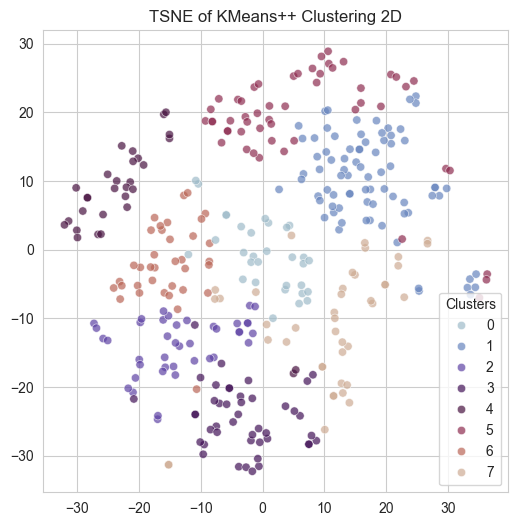

In [28]:
plt.figure(figsize=(6,6))
sns.scatterplot(
    x= x_embedded_2d[:, 0], y=x_embedded_2d[:, 1],
    hue=clusters,
    palette=sns.color_palette("twilight",8),
    data=df_scaled,
    alpha=0.7
    )
plt.title('TSNE of KMeans++ Clustering 2D')
plt.legend(title='Clusters') 
plt.show()

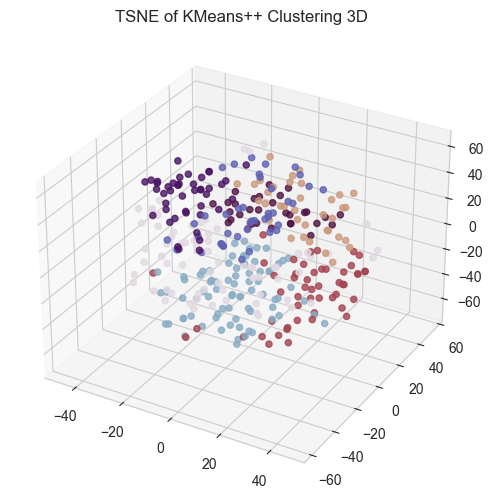

In [29]:
ax = plt.figure(figsize=(6,6)).add_subplot(projection = '3d')
ax.scatter(
    xs= x_embedded_3d[:, 0], 
    ys= x_embedded_3d[:, 1],
    zs= x_embedded_3d[:, 2],
    c=clusters,
    cmap='twilight',
    alpha=0.8,
)
plt.title('TSNE of KMeans++ Clustering 3D')
plt.show()